In [1]:
import numpy as np
import os,glob,pickle

from ioMicroSimple import *

In [2]:
dic_pos_fl = r'Z:/MERFISHp/12_16_2025_BigSlideTest/dic_pos_pixf.pkl'
dic_pos = pickle.load(open(dic_pos_fl,'rb'))

### Check deconvolution

In [3]:

if False:
    fov= fovs[44]
    fl = rf'Z:/MERFISHp/12_16_2025_BigSlideTest/H1_MER_set{iset}/{fov}.zarr'
    immed = np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\V2_med3.npy')
    immed=immed/np.median(immed)
    immed = cv2.blur(immed,(20,20))
    im_dapi = np.array(read_im(fl)[-1],dtype=np.float32)/immed
    imdo = full_deconv(im_dapi,s_=400,pad=100,psf=np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\psf_single.npy'),
                parameters={'method': 'wiener', 'beta': 0.005, 'niter': 50},gpu=True,force=False)
    
    #img = np.clip(imdo[:,::3,::3]/50000,0,1)

In [4]:
pix_size = [4,3,3]
im_shape = [40,2800,2800]
X = np.indices([im_shape[0]//pix_size[0],im_shape[1]//pix_size[1],im_shape[2]//pix_size[2]])
Xr = X.copy()
Xr = Xr.reshape([3,-1]).T
shape_red = X.shape[1:]
X = X.reshape([3,-1]).T*pix_size
X = X
MA = np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy')

MAi = calc_color_matrix(X[::7],apply_colorcor(X[::7],MA),order=4)
Xi = apply_colorcor(X,MAi)
Xi = np.round(Xi).astype(int)

keep = np.all((Xi>=0)&(Xi<im_shape),axis=-1)
imred = np.zeros(shape_red,dtype=np.float32)
#imred[tuple(Xr[keep].T)]=imdo[tuple(Xi[keep].T)]
imred = imred[1:-1]

In [5]:
iset=4
for iset in np.arange(10)+1:
    tiffl=rf'Z:\MERFISHp\12_16_2025_BigSlideTest\final_spots\dapi_set{iset}.tif'
    if not os.path.exists(tiffl):
        fovs,pos_pix = zip(*[(fov,dic_pos[fov]) for fov in dic_pos if f'zscan{iset}_' in fov])
        isort = np.argsort(fovs)
        fovs = np.array(fovs)[isort]
        pos_pix = np.array(pos_pix)[isort]-np.min(pos_pix,axis=0)
        
        pad=10
        pos_pix_mos = np.round(pos_pix/pix_size[1:]).astype(int)+pad
        szmos = np.max(pos_pix_mos,axis=0)+pad+imred.shape[1:]
        
        final_mosaic = np.zeros([imred.shape[0]]+list(szmos),dtype=np.float32)
        mosaic_mark = np.zeros(szmos,dtype=np.uint8)
        for ifov,(xst,yst) in enumerate(tqdm(pos_pix_mos)):
            xsz,ysz = imred.shape[1:]
            mosT = mosaic_mark[xst-pad:xst+pad+xsz,yst-pad:yst+pad+ysz]
            mosT[pad:-pad,pad:-pad]+=2
        
            Xoverlap = np.array(np.where(mosT==3)).T#-pad
            X1 = np.array(np.where((mosT==0)|(mosT==2))).T
            X0 = np.array(np.where((mosT==1))).T
            d1,_ = KDTree(X1).query(Xoverlap)
            d0,_ = KDTree(X0).query(Xoverlap)
            d1 = d1-1
            d0 = d0-1
            Xoverlap = Xoverlap-pad
            imgrad = np.ones([xsz,ysz],dtype=np.float32)
            imgrad[tuple(Xoverlap.T)]=d0/(d1+d0)
            imgrad[np.isnan(imgrad)]=1
            
            
            mosaic_mark[xst:xst+xsz,yst:yst+ysz]=1
        
            fov= fovs[ifov]
            fl = rf'Z:/MERFISHp/12_16_2025_BigSlideTest/H1_MER_set{iset}/{fov}.zarr'
            immed = np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\V2_med3.npy')
            immed=immed/np.median(immed)
            immed = cv2.blur(immed,(20,20))
            im_dapi = np.array(read_im(fl)[-1],dtype=np.float32)/immed
            imdo = im_dapi
            imdo = full_deconv(im_dapi,s_=400,pad=100,psf=np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\psf_single.npy'),parameters={'method': 'wiener', 'beta': 0.005, 'niter': 50},gpu=True,force=False)
            imred = np.zeros(shape_red,dtype=np.float32)
            imred[tuple(Xr[keep].T)]=imdo[tuple(Xi[keep].T)]
            imred = imred[1:-1]
            imgrad3d = np.repeat(imgrad[np.newaxis],imred.shape[0],0)
            imgrad3d[imred<=0]=0
            final_mosaic[:,xst:xst+xsz,yst:yst+ysz] = final_mosaic[:,xst:xst+xsz,yst:yst+ysz]*(1-imgrad3d)+imred*imgrad3d
        import tifffile
        final_mosaicF = (np.clip(final_mosaic[:,pad:,pad:]/50000,0,1)*255).astype(np.uint8)
        tifffile.imwrite(
            tiffl, 
            final_mosaicF, 
            bigtiff=True, 
            compression='zlib'
        )    

In [9]:
import napari
napari.view_image(final_mosaicF)

C:\Users\miket\AppData\Local\Temp\ipykernel_10412\2221517239.py:2: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  napari.view_image(final_mosaicF)


Viewer(camera=Camera(center=(0.0, np.float64(13861.0), np.float64(9816.5)), zoom=np.float64(0.02741406052735995), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(3.0), 1.0, 0.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(7.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(27722.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(19633.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(3.0), np.float64(13861.0), np.float64(9816.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1)

In [140]:
np.load()

(8, 13496, 10817)

In [137]:
imTT = tifffile.imread(r'Z:\MERFISHp\12_16_2025_BigSlideTest\final_spots\dapi_set1.tif')

(8, 13506, 10827)

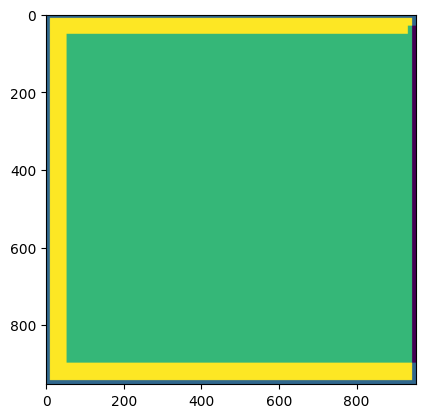

In [83]:
import matplotlib.pylab as plt
plt.imshow(mosT)

In [85]:
np.unique(mosT)

array([0, 1, 2, 3], dtype=uint8)

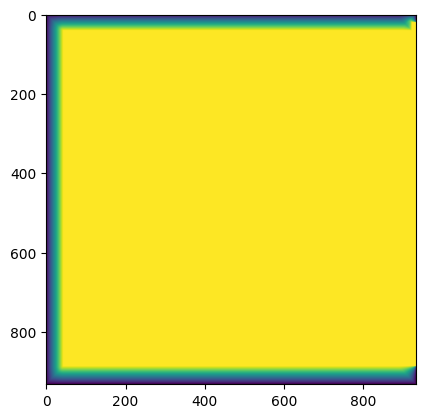

In [54]:
imred = np.zeros(shape_red,dtype=np.float32)
imred[tuple(Xr[keep].T)]=imdo[tuple(Xi[keep].T)]
imred = imred[1:-1]

8

In [40]:
import napari
napari.view_image(imred)

C:\Users\miket\AppData\Local\Temp\ipykernel_12280\3318276371.py:2: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  napari.view_image(imred)


Viewer(camera=Camera(center=(0.0, np.float64(466.0), np.float64(466.0)), zoom=np.float64(0.6109324758842444), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(3.0), 1.0, 0.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(7.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(932.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(932.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(3.0), np.float64(466.0), np.float64(466.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=F